In [113]:
import random
from glob import glob
import os 
import open3d as o3d

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

dirpath = '/home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734'
images = sorted(glob('{}/*.png'.format(dirpath)))
depth = sorted(glob('{}/*.exr'.format(dirpath)))

rotation_views = sorted(glob('../datasets/camera_settings/cam_RT/*.txt'))
idx = random.randint(0, len(images)-1)

print(f'Random index is : {idx}')

rgb_path = images[idx]
depth_path = depth[idx]
rotation_view = rotation_views[idx]

print(f'rgb : {rgb_path}, depth path : {depth_path}, rotation view : {rotation_view}')

Random index is : 19
rgb : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/color_020.png, depth path : /home/aditya/Research/phd/code/depth_renderer/datasets/ShapeNetRenderings/02818832/e91c2df09de0d4b1ed4d676215f46734/depth_020.exr, rotation view : ../datasets/camera_settings/cam_RT/cam_RT_020.txt


In [19]:
import matplotlib.pyplot as plt

512 512


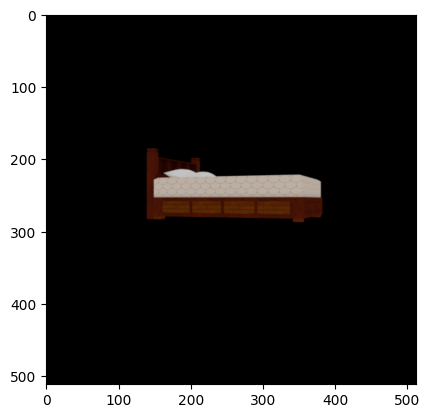

In [114]:
import cv2

# approach 1 -- camera parameters (intrinsics and extrinsics), depth image, and rgb image -- load the pointcloud
color_image = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_RGB2BGR)
depth_image = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)

height, width, _ = color_image.shape
print(height, width)

plt.imshow(color_image)

In [57]:
# get the camera parameters -- intrinsics and the extrinsics 
k_filename = '../datasets/camera_settings/cam_K/cam_K.txt'
with open(k_filename, 'r') as f:
    mat = [[int(float(num)) for num in line.split(' ')] for line in f]
    
fx, cx, fy, cy = mat[0][0], mat[0][2], mat[1][1], mat[1][2]

In [116]:
# create a pinhole camera with the camera intrinsics 
import numpy as np

intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width, 
        height,
        fx,
        fy,
        cx,
        cy
    )

color = o3d.geometry.Image(color_image)
depth = o3d.geometry.Image(depth_image.astype(np.float32)/0.5)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth, convert_rgb_to_intensity=False)
print(np.unique(depth_image))
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)

# pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

[1.8595996 1.8606641 1.8617285 1.862793  1.8638575 1.8649219 1.8659863
 1.8670508 1.8681152 1.8691797 1.8702441 1.8713086 1.8723731 1.8734375
 1.874502  1.8755664 1.8766308 1.8776953 1.8787597 1.8798243 1.8808887
 1.8819532 1.8830177 1.884082  1.8851465 1.8862109 1.8872755 1.8883399
 1.8894043 1.8904688 1.8915333 1.8925977 1.8936621 1.8947265 1.895791
 1.8968555 1.8979199 1.8989844 1.9000489 1.9011133 1.9021777 1.9032421
 1.9043067 1.9053711 1.9064356 1.9075    1.9085646 1.909629  1.9106933
 1.9117578 1.9128222 1.9138868 1.9149512 1.9160156 1.9170802 1.9181446
 1.919209  1.9202734 1.9213378 1.9224024 1.9234668 1.9245312 1.9255958
 1.9266602 1.9277246 1.928789  1.9298534 1.930918  1.9319824 1.9330469
 1.9341114 1.9351759 1.9362403 1.9373046 1.9383692 1.9394336 1.9404981
 1.9415625 1.942627  1.9436915 1.9447559 1.9458203 1.9468848 1.9479492
 1.9490137 1.9500781 1.9511425 1.9522071 1.9532715 1.9543359 1.9554003
 1.9564648 1.9575293 1.9585937 1.9596583 1.9607227 1.9617872 1.9628516
 1.9639

In [117]:
# visualize the pointcloud 
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.001)
o3d.visualization.draw_geometries([pcd, coordinate_frame]) # -- i just need to fix the viewpoint angle from the camera transformation matrix 

In [85]:
# read the rotation matrix from the file -- predefined view
with open(rotation_view, 'r') as f:
    rot_matrix = [[float(num) for num in line.split(' ')] for line in f]
    
rot_matrix = np.asarray(rot_matrix)
print(rot_matrix.shape)
print(f'The rotation matrix is : {rot_matrix}')

# transform the point cloud viewpoint by the rotation matrix 

(3, 4)
The rotation matrix is : [[ 3.56821895e-01  3.47145530e-08  9.34172571e-01 -1.78813934e-07]
 [ 3.47145530e-08 -1.00000012e+00 -1.30659856e-07  1.64305831e-07]
 [ 9.34172571e-01  1.78461818e-07 -3.56822044e-01  2.07846141e+00]]


In [26]:
# print(f'Translation matrix : {rot_matrix[:, -1]}') # this gives the translation -> shift the camera viewpoint 
# print(f'Rotation matrix : {rot_matrix[:, :-1]}') # this gives the rotation -> rotate the camera viewpoint 
T = rot_matrix[:, -1]
R = rot_matrix[:, :-1]

cam_pos = -T @ R
print(f'Camera position : {cam_pos}')

Camera position : [-1.19999931  1.20000062  1.20000048]


In [86]:
# let's just rotate the point cloud 
from copy import deepcopy

points = deepcopy(pcd.points)
points = (points - T).dot(R)

modified_pcd = deepcopy(pcd)
modified_pcd.points = o3d.utility.Vector3dVector(points)
# pcd.points = o3d.utility.Vector3dVector(points)

coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame() # prob need to change the focal length as well

o3d.visualization.draw_geometries([modified_pcd]) # --> this transformation view point works -- but do i need to change anything else?

In [94]:
# transform the pointcloud by a transformation matrix 
transformation = np.vstack([rot_matrix, [0, 0, 0, 1]])
print(transformation)
rotated_pcd = deepcopy(pcd)

rotated_pcd.transform(transformation)

o3d.visualization.draw_geometries([rotated_pcd])

[[ 3.56821895e-01  3.47145530e-08  9.34172571e-01 -1.78813934e-07]
 [ 3.47145530e-08 -1.00000012e+00 -1.30659856e-07  1.64305831e-07]
 [ 9.34172571e-01  1.78461818e-07 -3.56822044e-01  2.07846141e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [88]:
points = np.asarray(pcd.points)
colors = pcd.colors 
print(f'Original points are : {points}')

points = (points - T) @ R

print(f'Rotated points are : {points}')
rotated_pcd = o3d.geometry.PointCloud()
rotated_pcd.points = o3d.utility.Vector3dVector(points)
rotated_pcd.colors = o3d.utility.Vector3dVector(colors)

o3d.visualization.draw_geometries([rotated_pcd])

Original points are : [[ 0.0004108   0.00054089 -0.00383416]
 [ 0.00041742  0.00054059 -0.00383203]
 [ 0.00042402  0.00054029 -0.0038299 ]
 ...
 [ 0.0004962  -0.00020392 -0.00380648]
 [ 0.00050666 -0.0002054  -0.00383416]
 [ 0.00051721 -0.00020688 -0.00386184]]
Rotated points are : [[-1.2021433   1.20177264  1.20272543]
 [-1.20213727  1.20177165  1.20272876]
 [-1.20213124  1.20177067  1.20273208]
 ...
 [-1.20176286  1.20236479  1.20246577]
 [-1.20177085  1.20238198  1.20248854]
 [-1.20177876  1.20239917  1.20251137]]
